# **Telecom Customer Churn Prediction and Network Optimization**

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/AT%26T_logo_2016.svg/330px-AT%26T_logo_2016.svg.png) ![](https://pbs.twimg.com/profile_images/1593315582564352001/dCtNc6fr_400x400.jpg)![](https://1000logos.net/wp-content/uploads/2021/10/Xfinity-Logo-2010.png) ![](https://9to5google.com/wp-content/uploads/sites/4/2023/02/mint-mobile-logo-1.jpg?quality=82&strip=all)

# **Project Objective**

As more telecom companies emerge in the market, customers now have more options to choose from among the service providers. This selection process involves comparing prices, monthly usage, and coverage quality. Consequently, telecom companies need to swiftly adjust their market positions to target the right customers for them and expand their user base.

As a marketing consultant team, we aim to receive monthly updates on all interactions between customers and their chosen service providers. This will enable us to predict which customers are most likely to churn and which may provide valuable connections to others. In doing so, they can become the focal point of our targeting network.



## Spark Streaming

One important aspect of marketing analysis is having updated data so that the company's BI team can run ad-hoc queries whenever they need to look up the newest information.

In our case, we want to observe the monthly changes between customers and their service providers so that we know the current position of the leading telecoms and their corresponding market shares.

The first thing we need to do is to create our Spark session and set up our source streaming data directory:

#### Install PySpark and Create Spark Session

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
session= SparkSession.builder.appName("Group9").getOrCreate()

#### Load Data

In [3]:
telecom_data=session.read.csv("telecom_data_new.csv", inferSchema=True, header=True)

In [4]:
telecom_data.show()

+----------+-------------+------------+----------+------------------+--------------+------------------+------------------+--------------+----------------+---------+
|ProviderID|ConstructorID|AdCampaignID|CustomerID|   NetworkUsage_GB|ServiceQuality|AdvertisementReach|    EngagementRate|ConversionRate|CustomerFeedback|ChurnRisk|
+----------+-------------+------------+----------+------------------+--------------+------------------+------------------+--------------+----------------+---------+
|    Prov_1|      Const_1|        Ad_4|   Cust_17| 7.610704548881492|          Fair|              4362|0.1772607961540628|   0.031627842|         Neutral|       No|
|    Prov_1|      Const_3|        Ad_3|   Cust_14| 18.69521620515276|          Fair|              6311|0.1432249125631183|   0.033397969|         Neutral|       No|
|    Prov_3|      Const_3|        Ad_4|   Cust_43|19.457827167836577|     Excellent|              5463|       0.062491029|   0.046749754|        Negative|      Yes|
|    Prov_

In [5]:
print("Number of records:", telecom_data.count())
print("Information of columns:\n", telecom_data.columns)
print("Summary of datasert:\n", telecom_data.describe().show(truncate=False))

Number of records: 200
Information of columns:
 ['ProviderID', 'ConstructorID', 'AdCampaignID', 'CustomerID', 'NetworkUsage_GB', 'ServiceQuality', 'AdvertisementReach', 'EngagementRate', 'ConversionRate', 'CustomerFeedback', 'ChurnRisk']
+-------+----------+-------------+------------+----------+------------------+--------------+------------------+-------------------+--------------------+----------------+---------+
|summary|ProviderID|ConstructorID|AdCampaignID|CustomerID|NetworkUsage_GB   |ServiceQuality|AdvertisementReach|EngagementRate     |ConversionRate      |CustomerFeedback|ChurnRisk|
+-------+----------+-------------+------------+----------+------------------+--------------+------------------+-------------------+--------------------+----------------+---------+
|count  |200       |200          |200         |200       |200               |200           |200               |200                |200                 |200             |200      |
|mean   |NULL      |NULL         |NULL    

#### Set up streaming directory

In [6]:
#Create a folder named telecomdir and set up the readStream
stream_csv=session.readStream.option("header", "true").schema(telecom_data.schema).csv("telecomdir/")

In [7]:
#Copy the json file to the DoctorDir folder
import shutil
src=r"telecom_data_new.csv"
dest=r"telecomdir"
shutil.copy(src,dest)

'telecomdir/telecom_data_new.csv'

In [8]:
# Set up the write stream
stream_csv.writeStream.queryName("telecomTable").format("memory").outputMode("append").start()

#### Simulate arrival of monthly new data and perform ad-hoc queries

In [9]:
import time
for i in range(10):
    session.sql(
        '''
        SELECT
          ProviderID,
          COUNT(CustomerID) AS NumberOfCustomers,
          ROUND(COUNT(CustomerID) * 100.0 / (SELECT COUNT(CustomerID) FROM telecomTable), 3) AS MarketSharePercentage
        FROM
            telecomTable
        GROUP BY
            ProviderID
        ORDER BY
            MarketSharePercentage DESC
        ''').show()

    newfile="telecomdir/telecom_data_new" + str(i) +  ".csv"
    shutil.copy(src,newfile)
    time.sleep(6)

+----------+-----------------+---------------------+
|ProviderID|NumberOfCustomers|MarketSharePercentage|
+----------+-----------------+---------------------+
+----------+-----------------+---------------------+

+----------+-----------------+---------------------+
|ProviderID|NumberOfCustomers|MarketSharePercentage|
+----------+-----------------+---------------------+
|    Prov_2|              100|               25.000|
|    Prov_1|               86|               21.500|
|    Prov_3|               76|               19.000|
|    Prov_5|               72|               18.000|
|    Prov_4|               66|               16.500|
+----------+-----------------+---------------------+

+----------+-----------------+---------------------+
|ProviderID|NumberOfCustomers|MarketSharePercentage|
+----------+-----------------+---------------------+
|    Prov_2|              150|               25.000|
|    Prov_1|              129|               21.500|
|    Prov_3|              114|              

## Machine Learning

An important part of securing market share is to understand your customer. Customer satisfaction is one of the indicators of whether a customer will continue to sign up with one telecom company. But, we have more information than that! Therefore, our goal is to find out the model that could give us the best accuracy in predicting the churn risk of a customer.

Before we can input our data into the classification model, let's take a look to see if any of the columns (features) might need transformation. One-hot encoding is one of the common methods used to provide a vector for the machine learning model:

### Load Data

In [10]:
telecom_customer=session.read.csv("telecom_data_customer.csv", inferSchema=True, header=True)

In [11]:
#Take a look at the first 5 rows
telecom_customer.show(5)

+----------+----------+------------+-------------+---------------+-----------+------------+--------------+------------------+--------------+--------------+----------------+---------+
|CustomerID|ProviderID|DataPerMonth|PricePerMonth|NetworkUsage_GB|WifiCalling|ShareHotspot|ServiceQuality|AdvertisementReach|EngagementRate|ConversionRate|CustomerFeedback|ChurnRisk|
+----------+----------+------------+-------------+---------------+-----------+------------+--------------+------------------+--------------+--------------+----------------+---------+
|   Cust_69|    Prov_1|           5|        56.85|            5.0|         NO|         YES|          Fair|               839|   0.177260796|   0.031627842|         Neutral|       No|
|  Cust_160|    Prov_1|          20|        50.66|    18.69521621|        YES|         YES|          Fair|               768|   0.143224913|   0.033397969|         Neutral|       No|
|  Cust_156|    Prov_3|          15|        32.68|           15.0|        YES|       

### Build Machine Learning Pipeline

In [12]:
#Using string indexing for dependent variable and categorical independent variables
#Classification Models need the dependent variable to be numeric,
#Hence important to convert dependent variable in numeric form
from pyspark.ml.feature import StringIndexer
str_obj=StringIndexer(inputCols=["ProviderID", "WifiCalling", "ShareHotspot", "ServiceQuality", "CustomerFeedback", "ChurnRisk"],
                      outputCols=["newProviderID", "newWifiCalling", "newShareHotspot", "newServiceQuality", "newCustomerFeedback", "newChurnRisk"], stringOrderType="alphabetAsc")

In [13]:
#Using one hot encoding for categorical variables
from pyspark.ml.feature import OneHotEncoder
onehot_obj=OneHotEncoder(inputCols=["newProviderID", "newServiceQuality", "newCustomerFeedback"],
                         outputCols=["finalProviderID", "finalServiceQuality", "finalCustomerFeedback"])

In [14]:
from pyspark.ml.feature import VectorAssembler
vec_obj=VectorAssembler(inputCols=["finalProviderID", "DataPerMonth", "PricePerMonth", "NetworkUsage_GB", "newWifiCalling", "newShareHotspot", "finalServiceQuality", "AdvertisementReach", "finalCustomerFeedback"],
                        outputCol="all_features")

### Model Training

In [15]:
#Creating a logistic regression model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='all_features', labelCol="newChurnRisk")

#Creating a pipeline
from pyspark.ml import Pipeline
lr_pipeline=Pipeline(stages=[str_obj, onehot_obj, vec_obj, lr])

In [16]:
#Splitting the dataset into train and test
train, test=telecom_customer.randomSplit([0.8, 0.2], seed=123)

#Training the model
lr_model=lr_pipeline.fit(train)

#Predicting the results on test dataset
lr_results=lr_model.transform(test)

#Displaying the results
lr_results.show(2, truncate=False)

+----------+----------+------------+-------------+---------------+-----------+------------+--------------+------------------+--------------+--------------+----------------+---------+-------------+--------------+---------------+-----------------+-------------------+------------+---------------+-------------------+---------------------+--------------------------------------------------------------------------+------------------------------------------+----------------------------------------+----------+
|CustomerID|ProviderID|DataPerMonth|PricePerMonth|NetworkUsage_GB|WifiCalling|ShareHotspot|ServiceQuality|AdvertisementReach|EngagementRate|ConversionRate|CustomerFeedback|ChurnRisk|newProviderID|newWifiCalling|newShareHotspot|newServiceQuality|newCustomerFeedback|newChurnRisk|finalProviderID|finalServiceQuality|finalCustomerFeedback|all_features                                                              |rawPrediction                             |probability                            

### Model Evaluation

In [17]:
#Evaluating the result
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Calculate the accuracy
lr_results=lr_results.withColumn("compare", lr_results['newChurnRisk']-lr_results['prediction'])
correct=lr_results.filter(lr_results['compare']==0).count()
incorrect=lr_results.filter(lr_results['compare']!=0).count()
print(correct/(correct+incorrect))

0.7073170731707317


In [18]:
#Calculate the Logistic Regression AUC
evaluator = BinaryClassificationEvaluator(labelCol="newChurnRisk", rawPredictionCol="probability", metricName="areaUnderROC")
auc = evaluator.evaluate(lr_results)
print(f"Test AUC: {auc}")

Test AUC: 0.7356321839080456


Although our model currently has an accuracy of 70%, we want to explore ways to improve it. One approach is through **feature engineering**.

For instance, we are considering the **creation of new columns**, such as the remaining data at the end of the month. This is based on the rationale that customers who consistently purchase more data than they need might consider switching to another service provider. Additionally, we plan to **rescale our advertisement reach metrics**, as their wide range compared to other features could potentially skew the model's bias.

Furthermore, we intend to move beyond traditional logistic regression. We plan to employ the **bagging technique with a random forest model** to decrease our model's variance without increasing bias (which is known as **ensemble methods**). This method should help enhance the model's overall performance.


## Feature Engineering and Ensemble Methods

### Add DataRemian Column

In [19]:
#Create new columns
telecom_customer = telecom_customer.withColumn('DataRemain', telecom_customer['DataPerMonth'] - telecom_customer['NetworkUsage_GB'])

In [20]:
telecom_customer.show()

+----------+----------+------------+-------------+---------------+-----------+------------+--------------+------------------+--------------+--------------+----------------+---------+------------------+
|CustomerID|ProviderID|DataPerMonth|PricePerMonth|NetworkUsage_GB|WifiCalling|ShareHotspot|ServiceQuality|AdvertisementReach|EngagementRate|ConversionRate|CustomerFeedback|ChurnRisk|        DataRemain|
+----------+----------+------------+-------------+---------------+-----------+------------+--------------+------------------+--------------+--------------+----------------+---------+------------------+
|   Cust_69|    Prov_1|           5|        56.85|            5.0|         NO|         YES|          Fair|               839|   0.177260796|   0.031627842|         Neutral|       No|               0.0|
|  Cust_160|    Prov_1|          20|        50.66|    18.69521621|        YES|         YES|          Fair|               768|   0.143224913|   0.033397969|         Neutral|       No|1.30478378

In [21]:
#Update our VectorAssemble
from pyspark.ml.feature import VectorAssembler
vec_obj2=VectorAssembler(inputCols=["finalProviderID", "DataPerMonth", "PricePerMonth", "NetworkUsage_GB", "DataRemain", "newWifiCalling", "newShareHotspot", "finalServiceQuality", "AdvertisementReach", "finalCustomerFeedback"],
                        outputCol="all_features")

### Min Max Scaling

In [22]:
#Min Max Scaling
from pyspark.ml.feature import MinMaxScaler

#A min max scalar is always applied only on a vector
mm = MinMaxScaler(inputCol="all_features", outputCol="all_features_scaled")

### Bagging with Random Forest

In [23]:
#Create the model based on Random Forest algorithm
from pyspark.ml.classification import RandomForestClassifier

#Use bagging for our feature selection, "all" means using all the features at every split
rf = RandomForestClassifier(featuresCol="all_features_scaled", labelCol="newChurnRisk",
                            numTrees=20, featureSubsetStrategy="all", seed=123)

In [24]:
#Assemble the pipeline
rf_pipeline = Pipeline(stages=[str_obj, onehot_obj, vec_obj2, mm, rf])

In [25]:
# #Splitting the dataset into train and test
train, test=telecom_customer.randomSplit([0.8, 0.2], seed=123)

#Training the model
rf_model=rf_pipeline.fit(train)

#Predicting the results on test dataset
rf_results=rf_model.transform(test)

#Displaying the results
rf_results.show(2, truncate=False)

+----------+----------+------------+-------------+---------------+-----------+------------+--------------+------------------+--------------+--------------+----------------+---------+------------------+-------------+--------------+---------------+-----------------+-------------------+------------+---------------+-------------------+---------------------+---------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------+---------------------------------------+----------------------------------------+----------+
|CustomerID|ProviderID|DataPerMonth|PricePerMonth|NetworkUsage_GB|WifiCalling|ShareHotspot|ServiceQuality|AdvertisementReach|EngagementRate|ConversionRate|CustomerFeedback|ChurnRisk|DataRemain        |newProviderID|newWifiCalling|newShareHotspot|newServiceQuality|newCustomerFeedback|newChurnRisk|finalProviderID|finalServiceQuality|

In [26]:
#Evaluating the result
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Verifying the Results
rf_results=rf_results.withColumn("compare", rf_results['newChurnRisk']-rf_results['prediction'])
correct2=rf_results.filter(rf_results['compare']==0).count()
incorrect2=rf_results.filter(rf_results['compare']!=0).count()
print(correct2/(correct2+incorrect2))

0.8048780487804879


Yes, it did improve! As we create more useful feature engineering columns or experiment with different sets of parameters (like the depth of trees/number of features selected at every split), our model's predictions will become more accurate.

## Reevaluation

### Using ROC for Model Comparison

In [27]:
#Calculate the Random Forest AUC
evaluator2 = BinaryClassificationEvaluator(labelCol="newChurnRisk", rawPredictionCol="probability", metricName="areaUnderROC")
auc2 = evaluator2.evaluate(rf_results)
print(f"Test AUC: {auc2}")

Test AUC: 0.7586206896551724


In [28]:
from sklearn.metrics import roc_curve, auc

#Extract probabilities for the positive class (index 1 of the probability vector)
rf_probabilities = rf_results.select("probability").rdd.map(lambda row: row[0][1]).collect()
lr_probabilities = lr_results.select("probability").rdd.map(lambda row: row[0][1]).collect()

#Extract the true labels
rf_labels = rf_results.select("newChurnRisk").rdd.map(lambda row: row[0]).collect()
lr_labels = lr_results.select("newChurnRisk").rdd.map(lambda row: row[0]).collect()

#Calculate the ROC curve data points
fpr_rf, tpr_rf, _ = roc_curve(rf_labels, rf_probabilities)
fpr_lr, tpr_lr, _ = roc_curve(lr_labels, lr_probabilities)

#Calculate the AUC for each model
auc_rf = auc(fpr_rf, tpr_rf)
auc_lr = auc(fpr_lr, tpr_lr)

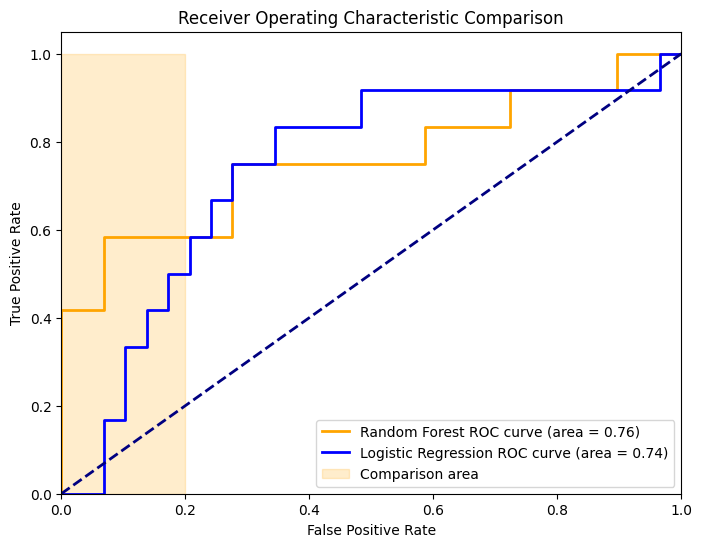

In [29]:
#Plot the ROC curve
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ROC curve (area = {auc_rf:.2f})', color='orange', lw=2)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression ROC curve (area = {auc_lr:.2f})', color='blue', lw=2)

# Highlight the area before 0.2 false positive rate
plt.fill_betweenx([0, 1], 0, 0.2, color='orange', alpha=0.2, label='Comparison area')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc="lower right")
plt.show()

Considering the telecom market, as service providers, **we care more about false negatives since they are "expensive"—meaning that we would rather identify all the customers who will churn (at the cost of mistakenly classifying some customers who will stay anyway)**. In this case, our logistic regression model might have strictly better performance.

With similar AUCs for both models, although the random forest model correctly predicts more outcomes, **the logistic regression model might be better at distinguishing between the positive and negative classes when we consider a false positive rate acceptance threshold under 0.2.**

In summary, the choice of model depend on the specific business context and cost-benefit analysis of different types of errors. In our cases, if we want to maintain a low false positive rate (high true negative), then the logistic regression might be preferred despite its slightly lower overall accuracy.